*NOTE: The Homework looks longer than it really is! (but do get started soon!)* Execute all the cells in the notebook as you go along and answer all the Quizzes.
Also note that we have tested this on Google colab, so if you are using something else, there might be missing packages.
This question is worth 40 points, you can use Table of Contents to navigate the notebook by clicking on the three horizontal bars on the left.

# Introduction

It is year 2035, and GPT15 has spawned "EE274GPT", an LLM finetuned on the EE274 course notes. EE274GPT is a friendly GPT who wants to help the world by designing better compression algorithms.

In its quest to do this, it is trying to "re-invent" JPEG image compression, using what it learnt from Pulkit's lectures on transform coding: [L13](https://stanforddatacompressionclass.github.io/Fall23/static_files/slide_13_2023_ann.pdf), [L14](https://stanforddatacompressionclass.github.io/Fall23/static_files/L14.pdf). Recall that Transform coding works in three steps:

- Step-1:  Transforming the data stream into uncorrelated samples
- Step-II: Quantize the transform coefficients
- Step-III: Losslessly encode these transformed coefficients

Let's first set up some dependencies and some basic utility functions.

In [2]:
# Lets install Huggingface datasets library
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00


In [3]:
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib import gridspec
import plotly.express as px
import datasets
import os
%matplotlib inline

In [4]:
## General utility functions on images

def read_image(image_path):
    img = Image.open(image_path)
    return img

def downscale_image(img, downscale_factor=None):
    if downscale_factor is None:
        return img

    new_width = int(img.width//downscale_factor)
    new_height = int(img.height//downscale_factor)

    # Resize the image
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return img

def convert_to_grayscale(img):
    img = img.convert('L')  # Convert to grayscale
    return img

def convert_img_to_np_01(img):
    """
    converts img to a float in [0,1] range
    """
    img_arr = np.array(img)/255.0
    return img_arr


def display_blocks(blocks, blocks_per_row, vmin=0, vmax=1, figsize=(5,5)):
    num_blocks = len(blocks)
    num_rows = math.ceil(num_blocks / blocks_per_row)

    fig, axes = plt.subplots(num_rows, blocks_per_row, figsize=figsize)
    axes = axes.ravel()

    for i in range(num_rows * blocks_per_row):
        if i < num_blocks:
            axes[i].imshow(blocks[i], cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def array_to_blocks(arr, block_size):
    """
    2D array [H,W] to [num_blocks, block_size, block_size]
    """
    H, W = arr.shape

    H = (H //block_size)*block_size
    W = (W //block_size)*block_size
    arr = arr[:H, :W]

    # Reshape and transpose to get blocks
    return (arr.reshape(H // block_size, block_size, -1, block_size)
              .swapaxes(1, 2)
              .reshape(-1, block_size, block_size))

def blocks_to_array(blocks, H, W):
    """
    inverse of array_to_blocks
    """
    Bh, Bw = blocks.shape[1], blocks.shape[2]

    # Ensure that the total number of elements matches
    if blocks.size != H * W:
        raise ValueError("Total number of elements in blocks does not match the expected array size")

    # Reshape back to the original array
    return (blocks.reshape(H // Bh, W // Bw, Bh, Bw)
                  .swapaxes(1, 2)
                  .reshape(H, W))

# Transform coding

Similar to JPEG, EE274GPT proceeds by trying to apply the transform coding on blocks of images.
EE274GPT starts with the Step-I of finding a linear transform which un-correlates these blocks.

For simplicity we operate on grayscale images as shown below. Let us start with downloading the 'Kodak' dataset and visualizing samples from this dataset. This dataset consists of "RAW" images before any compression.


In [5]:
# Kodak dataset
dataset = load_dataset("Freed-Wu/kodak")['test']

Extracting data files:   0%|          | 0/24 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/24 [00:00<?, ? examples/s]

Image dimensions: (512, 768)


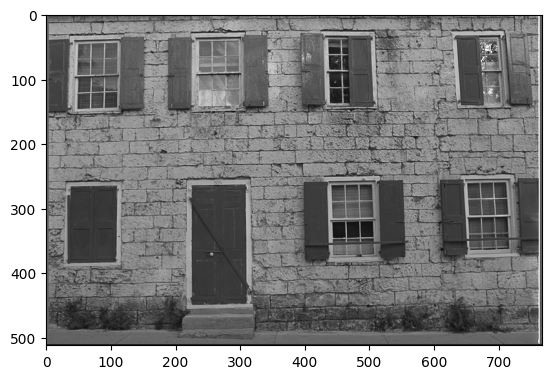

In [6]:
# Let us look at sample 0 from the dataset
sample_img_rgb = dataset[0]['image']
sample_img = convert_to_grayscale(sample_img_rgb)
img_arr = convert_img_to_np_01(sample_img)
plt.imshow(img_arr, cmap='gray')
print(f"Image dimensions: {img_arr.shape}")

Image dimensions: (512, 768)


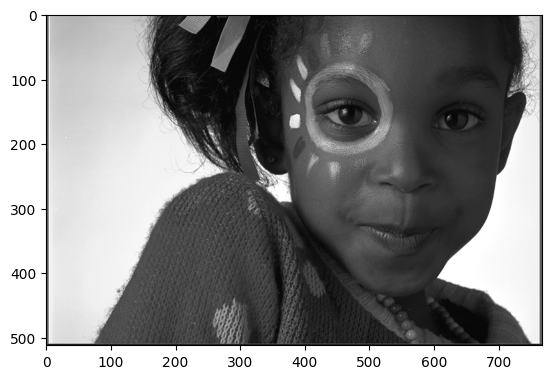

In [7]:
# Let us look at sample 14 from the dataset
sample_img_rgb = dataset[14]['image']
sample_img = convert_to_grayscale(sample_img_rgb)
img_arr = convert_img_to_np_01(sample_img)
plt.imshow(img_arr, cmap='gray')
print(f"Image dimensions: {img_arr.shape}")


## Covariance Matrix
Next, let's find the covariance matrix for the image block using the images in the Kodak dataset. Recall that if $[X_0,\ldots, X_{n-1}]$ is our n-dimentional random variable, then $(i,j)$ element of the covariance matrix $M$ (of size $n\times n$) is defined as

$$M_{ij} = E[X_i X_j] - mean(X_i)*mean(X_j)$$

where the **first term defines the correlation matrix**. Given a dataset, this can be computed using the empirical average across the blocks in all the images.

In our case $[X_0, \ldots, X_{n-1}]$ correspond to the flattenend elements of the block ($n$ = BLOCK_SIZE*BLOCK_SIZE).





---
### Quiz1.1 (6 points)

EE274GPT is able to write most of the code to find the covariance matrix, but it messes up a few key lines. Can you help out EE274GPT by completing the function `find_covariance_mean` to compute the covariance matrix and mean over the blocks of images?

---

In [8]:
# Lets start with computing the covariance matrix:
def find_covariance_mean(dataset, BLOCK_SIZE):

    # keep cache variables
    correlation = np.zeros((BLOCK_SIZE*BLOCK_SIZE, BLOCK_SIZE*BLOCK_SIZE))
    mean = np.zeros((BLOCK_SIZE*BLOCK_SIZE))
    count = 0 # number of images processed

    # loop over images from the dataset
    for i,sample in tqdm(enumerate(dataset), total=len(dataset)):

        # we work with grayscale images for simplicity
        img = sample['image']
        img_gray = convert_to_grayscale(img)
        img_arr = convert_img_to_np_01(img_gray)

        # convert to [num_blocks, BLOCK_SIZE, BLOCK_SIZE] numpy array
        blocks_3d = array_to_blocks(img_arr, BLOCK_SIZE)

        ########################
        # ADD CODE HERE

        # You need to update the correlation and mean with contributions from blocks in
        # this image.
        # Note that correlation[i, j] maintains the average of the product of
        # i'th and j'th pixel value across blocks. Whereas the mean[i] maintains the
        # average of the pixel value of i'th pixel across blocks. The indices i, j
        # here lie in the range [0, BLOCK_SIZE*BLOCK_SIZE - 1] so you might need
        # need to deal with blocks_3d appropriately.

        # You can assume that all images have the same number of blocks so you can
        # first compute the average across the blocks in the image blocks and
        # then incremented the running average of correlation and mean across images
        # using the count variable.
        ########################
        mean_tmp = np.zeros((BLOCK_SIZE*BLOCK_SIZE))
        correlation_tmp = np.zeros((BLOCK_SIZE*BLOCK_SIZE, BLOCK_SIZE*BLOCK_SIZE))
        for block in blocks_3d:
            flat_block = block.flatten()

            mean_tmp += flat_block

            correlation_tmp += np.outer(flat_block, flat_block)
        mean_tmp /= len(blocks_3d)
        correlation_tmp /= len(blocks_3d)
        mean += mean_tmp
        correlation += correlation_tmp

        count += 1
    mean /= count
    correlation /= count

    covariance = correlation - mean.reshape(-1,1)*(mean.reshape(-1,1).T)
    return covariance, mean

Now let's verify your implementation with a test. **Make sure your test passes before proceeding ahead.** The code provided for the test can also be useful for the later parts if you have difficulties with the implementation above.

In [9]:
# test covariance matches as expected using a naive implementation that collects
# all blocks and uses numpy's provided functions instead of incremental changes
# and going via the correlation as you did.
def find_covariance_mean_ground_truth(dataset, BLOCK_SIZE):
    # Initialize a list to hold all flattened blocks
    all_flattened_blocks = []

    # Loop over images - apply array_to_blocks and flatten each block
    for sample in dataset:
        img = sample['image']
        img_gray = convert_to_grayscale(img)
        img_arr = convert_img_to_np_01(img_gray)
        blocks_3d = array_to_blocks(img_arr, BLOCK_SIZE)
        flattened_blocks = blocks_3d.reshape(-1, BLOCK_SIZE * BLOCK_SIZE)
        all_flattened_blocks.append(flattened_blocks)

    # Stack all flattened blocks into a single 2D array
    all_blocks_2d = np.vstack(all_flattened_blocks)

    # Compute mean and covariance
    mean = np.mean(all_blocks_2d, axis=0)
    covariance = np.cov(all_blocks_2d, rowvar=False, bias=True)

    return covariance, mean

# test that the two implementations are identical on the Kodak dataset with block size 4x4
def test_covariance_impl():
    block_size = 2
    covariance_ground_truth, mean_ground_truth = find_covariance_mean_ground_truth(dataset, block_size)
    covariance_implemented, mean_implemented = find_covariance_mean(dataset, block_size)
    print(mean_ground_truth)
    print(mean_implemented)
    assert np.allclose(mean_ground_truth, mean_implemented), "Mean doesn't match"
    assert np.allclose(covariance_ground_truth, covariance_implemented), "Covariance doesn't match"
    print()
    print("All tests pass 🎉")
test_covariance_impl()

100%|██████████| 24/24 [00:27<00:00,  1.15s/it]

[0.43347107 0.43323979 0.43248522 0.43223564]
[0.43347107 0.43323979 0.43248522 0.43223564]

All tests pass 🎉



---
### Quiz1.2 (2 points)

Lets start by computing the covariance matrix for white noise image dataset (run the next 3 cells) over BLOCK_SIZE=8. Your computed covariance matrix should look like an identity matrix. Explain why the covariance matrix looks this way in a sentence.  

Ans: There is no correlation between white noise image, the block is a random collection, so there is no covariance.

---


White noise image saved as 'white_noise.png' 
Image dimensions: (3000, 4000)


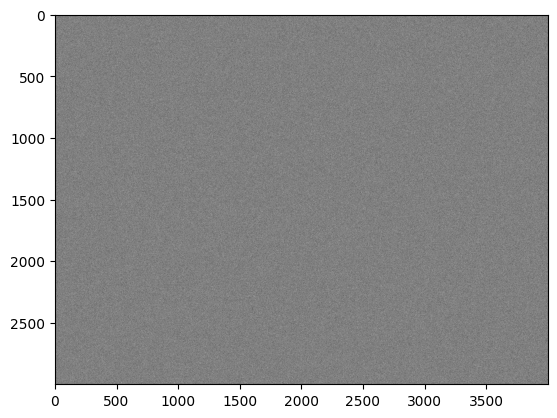

In [10]:
## First we'll generate a white noise image and look at it. Note that you need to zoom in to observe the random pixels.
# Define the dimensions of the image
width = 4000
height = 3000

# Generate a random white noise image
white_noise = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
image = Image.fromarray(white_noise)
image.save("white_noise.png")
print("White noise image saved as 'white_noise.png' ")

white_noise_dataset = datasets.Dataset.from_dict({"image": ["white_noise.png"]}).cast_column("image", datasets.Image())
white_noise_sample_img_rgb = white_noise_dataset[0]['image']
white_noise_sample_img = convert_to_grayscale(white_noise_sample_img_rgb)

# converts PIL Image to numpy array in [0,1]
white_noise_img_arr = convert_img_to_np_01(white_noise_sample_img)
plt.imshow(white_noise_img_arr, cmap='gray')
print(f"Image dimensions: {white_noise_img_arr.shape}")


Zooming into the image to show a small portion


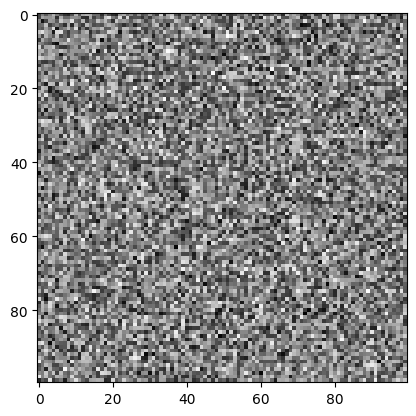

In [11]:
## Zooming into the white noise image
print("Zooming into the image to show a small portion")
plt.imshow(white_noise_img_arr[:100,:100], cmap='gray')

Now compute the covariance of the white noise image below and display.

100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


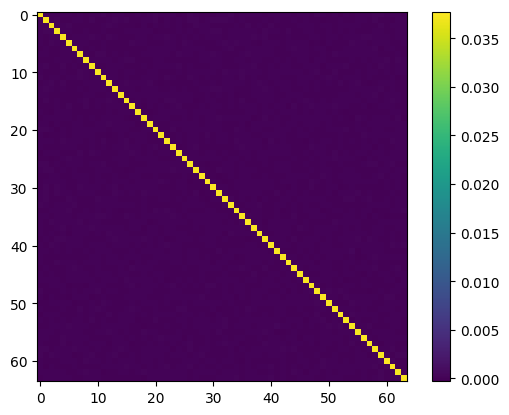

In [12]:
BLOCK_SIZE = 8
white_noise_covariance, white_noise_mean = find_covariance_mean(white_noise_dataset, BLOCK_SIZE=BLOCK_SIZE)

## Lets look at the covariance matrix:
shw = plt.imshow(white_noise_covariance)
plt.colorbar(shw)


---
Now let's compute the covariance matrix over natural images from the Kodak dataset over 8x8 blocks. Your covariance matrix for 8x8 blocks should look something like below:

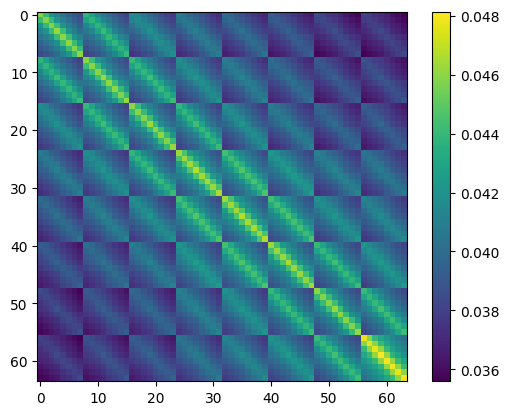

100%|██████████| 24/24 [00:02<00:00,  9.25it/s]


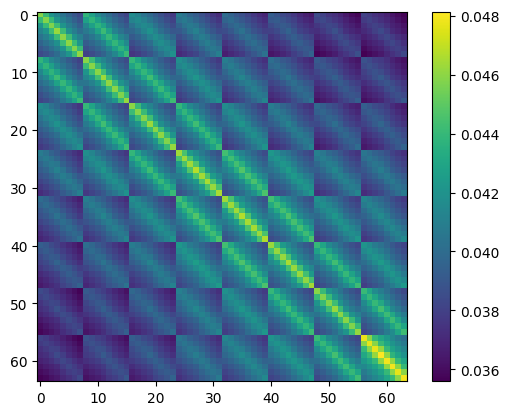

In [13]:
## Lets look at the covariance matrix for the Kodak dataset
BLOCK_SIZE = 8
covariance, mean = find_covariance_mean(dataset, BLOCK_SIZE=BLOCK_SIZE)
shw = plt.imshow(covariance)
plt.colorbar(shw)


---
### Quiz 1.3 (8 points)

Do you see any patterns? Briefly answer the following questions:
1. Explain why the highest values are along the diagonal, and the smallest values in the top right and bottom left corners.
2. Along with the central diagonal, there are other two prominent diagonals which start from (0,8) and (8,0). Can you guess why those values are higher?
3. Also, we observe a "blocky" pattern in blocks of 8x8. Why 8x8 patterns?
4. Explain in a single sentence how this matrix is different than the one which we saw for white noise images, and why?
5. [for fun] Explain any other patterns you see?

Ans: 1. Because the diagonal is actually the same pixel, so they have the highest values. Also the closer pixels should be more correlated because a real image should be continuous. Thus, further pixels have less correlation, so the top right and bottom left which is the covariance between the furtherest two points (top left and bottom) right in the image have the smallest values.

2. Because the block is 8*8. So with distance 8 we are actually computing the variance between two consecutive pixels, so the covariance is high.

3. Because the block is 8*8, so it is not averaged globally and we see a blocky result.

4. It has a more clear pattern. Because it is a real image and it's pixels are consecutive, so there is a more obvious pattern in covariance matrix.

---



## Computing Eigenvectors and Eigenvalues

Now that EE274GPT is able to compute the covariance and mean, it next proceeds to find its eigenvalues and eigenvectors and use that for transform coding.
(Also known as the Karhunen Loeve Transform, check out the [L14](https://stanforddatacompressionclass.github.io/Fall23/static_files/L14_ann.pdf) for more details)

We can use the `compute_eigens` function written by EE274GPT to get the eigenvectors and eigenvalues over blocks of images. Note that the `compute_eigens` function returns eigenvectors in a descending order in terms of their eigenvalues (i.e. eigenvector with highest eigenvalue is top left and one with smallest is bottom right). Also note that the eigenvectors are displayed by reshaping it back to the 8x8 block. Run the code below to plot the eigenvectors and answer the questions.


In [14]:
def compute_eigens(correlation_matrix):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    return eigenvalues, eigenvectors

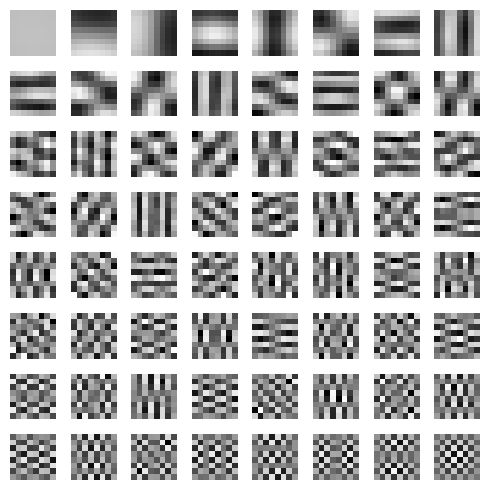

In [15]:
# Lets now compute the eigenvectors:
# The eigenvectors are sorted decendingly based on the eigenvalues and are columns of the eigenvectors matrix
eigenval, eigenvectors = compute_eigens(covariance)
eigen_blocks = [e.reshape(BLOCK_SIZE, BLOCK_SIZE) for e in eigenvectors.T]
display_blocks(eigen_blocks, BLOCK_SIZE, vmin=-0.25, vmax=0.25, figsize=(5,5))


In [16]:
# Lets also view the eigenvalues
import plotly.express as px
px.bar(eigenval, log_y=True, labels={"value": "eigenvalues (log scale)"}, title="Eigenvalues")


---
### Quiz 2.1 (5 points)

a. Compare these eigenvectors to the DCT transform used for JPEG codec. Do these look similar?

b. Intuitively explain why the first 3 eigenvectors and eigenvalues make sense

c. Let's also do the same exercise for white noise image dataset. Run the two cells below and explain how these eigenvalues and eigenvectors are different from the ones corresponding to natural images.

Ans: a. No. The DCT transforms are vertical and horizontal lines while these eigenvectors have different angles. Because of that these eigenvectors can capture more feature than DCT transforms.

b. Because they are the most prominent features, like common patterns or textures that across the image. So they are importent for recovering from a compressed image.

c. The real image eigenvectors look more neat, while these white noise eigenvectors look like random blocks. That is because the original image is white noise, so there is no reasonable pattern.

---

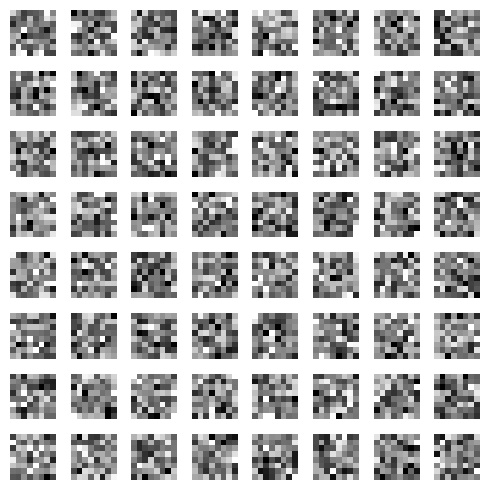

In [17]:
# Lets now compute the eigenvectors:
# The eigenvectors are sorted decendingly based on the eigenvalues and are columns og the eigenvectors matrix

# Note that since the covariance matrix is almost identity, any orthonormal basis will form eigenvectors of the matrix
# In particular, the matrix with eigenvectors as columns can even be the identity matrix, corresponding to identity transform.
# Even the DCT or the KLT above for natural images is an eigenvector basis!

white_noise_eigenval, white_noise_eigenvectors = compute_eigens(white_noise_covariance)
white_noise_eigen_blocks = [e.reshape(BLOCK_SIZE, BLOCK_SIZE) for e in white_noise_eigenvectors.T]
display_blocks(white_noise_eigen_blocks, BLOCK_SIZE, vmin=-0.25, vmax=0.25, figsize=(5,5))

In [18]:
df = pd.DataFrame({'x': range(64), 'Kodak dataset': eigenval, 'White noise': white_noise_eigenval})
df_melted = df.melt(id_vars='x', value_vars=['Kodak dataset', 'White noise'])
fig = px.bar(df_melted, log_y=True, x='x', y='value', color='variable', barmode='group',
             color_discrete_map={'Kodak dataset': 'red', 'White noise': 'blue'})
fig.show()


## Linear Transform

Lets now use the computed eigenvectors and eigenvalues for transforming the image. EE274GPT has implemented the `forward_block_transform` and `inverse_block_transform`. The `forward_block_transform` does the following:

- cuts the given image into blocks of shape `[BLOCK_SIZE, BLOCK_SIZE]`
- flattens out these blocks, and subtracts mean from them to center them
- use the eigenvectors to linearly transform them into transform coefficients.

The `inverse_block_transform` function does the reverse operation. As a sanity check we can verify that applying the forward and the inverse transforms we can fully retrieve back the image.



In [19]:
# Lets start by applying the transform on the image:
def forward_block_transform(img_arr, BLOCK_SIZE, mean, eigenvectors):
    img_blocks = array_to_blocks(img_arr, BLOCK_SIZE)
    img_blocks_2d = np.reshape(img_blocks, (-1, BLOCK_SIZE*BLOCK_SIZE))

    # subtract off the bias
    img_blocks_2d_centered = img_blocks_2d - mean

    # transform the blocks by multiplying by the eigenvectors:
    img_blocks_transformed_2d = (img_blocks_2d_centered.dot(eigenvectors)).T # BlOCK_SIZE*BLOCK_SIZE, N
    return img_blocks_transformed_2d

def inverse_block_transform(transformed_coeffs_2d, H, W, BLOCK_SIZE, mean, eigenvectors):
    # N, BlOCK_SIZE*BLOCK_SIZE
    reconst_2d = (eigenvectors.dot(transformed_coeffs_2d)).T + np.reshape(mean, (1,-1))
    reconst_3d = np.reshape(reconst_2d, (-1, BLOCK_SIZE,BLOCK_SIZE))
    return blocks_to_array(reconst_3d, H, W)

In [20]:
# Lets verify if the forward and inverse block transforms together are invertible
def mse(inp1, inp2):
    return np.square(np.subtract(inp1, inp2)).mean()

# BLOCK_SIZE*BLOCK_SIZE, N
H, W = img_arr.shape
transformed_coefficients = forward_block_transform(img_arr, BLOCK_SIZE, mean, eigenvectors)
reconstruction = inverse_block_transform(transformed_coefficients, H, W, BLOCK_SIZE, mean, eigenvectors)

mse_val = mse(img_arr, reconstruction)
assert mse_val < 1e-4
print(f"MSE between input and reconst: {mse_val:.5f}")


MSE between input and reconst: 0.00000


---
### Quiz 3.1 (4 points)

EE274GPT has implemented the interactive panel below, which shows the contribution of different eigenvectors in the input image. i.e. we apply the inverse transform by setting the transform coefficients to zero except for a specific component (Look at the function `keep_specific_eigenvectors` to understand more). Experiment with the slider bar and then answer the following questions in a couple of sentences:

1. Intuitively explain how the contribution from eigenvector 0 looks like as compared with the original image.

2. Intuitively explain the contributions corresponding to next couple eigenvectors. Do you see some pattern in these contribution images?

Ans: 1. Looks like the original image with lower precision. Because the 0th eigenvector is the most important one and can capture some important feature and detail, so that it helps to reconstruct the image.

2. The next couple eigenvectors also has some information about the original image, we can see the edge of the people using next couple eigenvectors. But it loses many details compared with eigenvector 0.

----


In [21]:
# Now lets see what happens if we only keep some of the transformed coefficients:
def keep_specific_eigenvectors(img_arr, keep_ind, mean, eigenvectors, block_size):
    transformed_coeffs_2d = forward_block_transform(img_arr, block_size, mean, eigenvectors)

    # only keep certain transform coefficients
    transformed_coeffs_2d_trimmed = 0*transformed_coeffs_2d
    transformed_coeffs_2d_trimmed[keep_ind,:] = transformed_coeffs_2d[keep_ind,:]
    reconst = inverse_block_transform(transformed_coeffs_2d_trimmed, H, W, block_size, mean, eigenvectors)
    return reconst

# lets visualize these eigenvectors:
# as we can see the first few eigenvectors have a significant contribution, beyond which it wanes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib import gridspec

columns=list(range(0,BLOCK_SIZE*BLOCK_SIZE))
def g(number_of_eigen_shown):
    reconst = keep_specific_eigenvectors(img_arr, number_of_eigen_shown, mean, eigenvectors, BLOCK_SIZE)
    reconst = np.clip(reconst, a_max=1.0, a_min=0.0)

    # create a figure
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                            width_ratios=[5, 1], wspace=0.1)

    ax1 = fig.add_subplot(spec[0])
    ax1.imshow(reconst, cmap='gray')
    # ax1.axis('off')  # Turn off axis for first image
    ax1.set_title('Eigenvector contribution')

    eigenvector = np.reshape(eigenvectors[:,number_of_eigen_shown], (BLOCK_SIZE, BLOCK_SIZE))
    ax2 = fig.add_subplot(spec[1])
    ax2.imshow(eigenvector, cmap='gray', vmin=-0.25, vmax=0.25)
    # ax2.axis('off')  # Turn off axis for second image
    ax2.set_title('Eigenvector')
    plt.show()

    # plt.imshow(reconst, cmap='gray')
    # fig.show()

interactive_plot = interact(g, number_of_eigen_shown=widgets.IntSlider(min=0, max=63, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='number_of_eigen_shown', max=63), Output()), _dom_classes…

<function __main__.g(number_of_eigen_shown)>

Looking at the contributions above, it is clear that the eigenvectors beyond the initial few do not have as much contribution (this can also be seen from the eigenvalues). To visualize this better, here is an interactive demo which only retains eigenvector contributions corresponding to the first few eigenvectors (as controlled by the slider).


In [22]:
def keep_until_eigenvectors(img_arr, keep_until, mean, eigenvectors, block_size):
    transformed_coeffs_2d = forward_block_transform(img_arr, block_size, mean, eigenvectors)

    # only keep certain transform coefficients
    transformed_coeffs_2d[keep_until+1:,:] = 0
    reconst = inverse_block_transform(transformed_coeffs_2d, H, W, block_size, mean, eigenvectors)
    return reconst

# lets visualize these eigenvectors:
# as we can see the first few eigenvectors have a significant contribution, beyond which it wanes

columns=list(range(0,BLOCK_SIZE*BLOCK_SIZE))
def g(number_of_eigen_shown):
    reconst = keep_until_eigenvectors(img_arr, number_of_eigen_shown, mean, eigenvectors, BLOCK_SIZE)
    reconst = np.clip(reconst, a_max=1.0, a_min=0.0)

    # create a figure
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                            width_ratios=[5, 1], wspace=0.1)

    ax1 = fig.add_subplot(spec[0])
    ax1.imshow(reconst, cmap='gray')
    # ax1.axis('off')  # Turn off axis for first image
    ax1.set_title(f'Reconstruction until Eigenvector {number_of_eigen_shown}')

    eigenvector = np.reshape(eigenvectors[:,number_of_eigen_shown], (BLOCK_SIZE, BLOCK_SIZE))
    ax2 = fig.add_subplot(spec[1])
    ax2.imshow(eigenvector, cmap='gray', vmin=-0.25, vmax=0.25)
    # ax2.axis('off')  # Turn off axis for second image
    ax2.set_title('Eigenvector')
    plt.show()

    # plt.imshow(reconst, cmap='gray')
    # fig.show()

interactive_plot = interact(g, number_of_eigen_shown=widgets.IntSlider(min=0, max=63, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='number_of_eigen_shown', max=63), Output()), _dom_classes…

<function __main__.g(number_of_eigen_shown)>

Notice that we need only a few eigenvectors (initial ~5-10) to obtain an acceptable reconstruction. Thus, this suggests a simple idea for compression which we saw in class:

- Transform the image using the eigenvectors, throw out all the eigenvector coefficients beyond the first 5 or 10 eigenvectors
- Quantize and losslessly compress the initial few eigenvector coefficients.

This should give us a reasonably good compressor. EE274GPT uses similar observations to implement an image compression algorithm.



# Image Codec

Let us combine the previous ideas into a image codec. Take a look at the `ImageCodec` class implemented by EE274GPT. The `ImageCodec::encode` function implemented by EE274GPT is shown below.
- Notice that it does something a bit smarter than just throwing out the eigenvector coefficients and uses ideas from waterfilling as described in the class to quantize the transform coefficients based on their importance, i.e. coefficients corresponding to first eigenvector are first scaled up by multiplying by a high value before quantization (done by simply rounding).

- The `ImageCodec` controls the average level distortion using a parameter called `theta`, which determines the amount by which to scale up the coefficients. We will not focus on this too much here, but the idea is that at higher `theta` we can tolerate higher distortion so we multiply with a smaller scaling factor before casting to integers.

- The `ImageCodec` then takes these rounded/quantized coefficients concatenates them and then losslessly encodes them using Bzip2 (recall that Bzip2 is the lossless compressor which uses concepts such as BWT and LZ which you saw in HW3).

---

## Quiz 4.1 (12 points)

EE274GPT was able to implement the `encode` function properly, but it messed up the `decode` function. Can you again step in and help complete the `decode` function?

As a hint, the `decode` function should essentially be the reverse of `encode` function. You do not need to completely understand the `Bzip2` and `RateController` components, you can just focus on the `ImageCodec`. Also you may try out the the `ImageCodec` encode/decode test function in the cell below.

---

In [23]:
# We will be using the BZIP2 compressor as our choice of lossless compressor
# NOTE: You don't need to understand what is happening here!
import bz2
class Bzip2:
    @classmethod
    def encode(cls, input_data_int8_flat_uint8):
        assert len(input_data_int8_flat_uint8.shape) == 1
        assert input_data_int8_flat_uint8.dtype == np.uint8
        raw_bytes = bytes(list(input_data_int8_flat_uint8))
        compressed_bytes = bz2.compress(raw_bytes)
        return compressed_bytes

    @classmethod
    def decode(cls, compressed_bytes):
        decoded_bytes = bz2.decompress(compressed_bytes)
        return np.array(list(decoded_bytes), dtype=np.uint8)


# Test for bzip2
img_uint8 = np.array(sample_img)
img_uint8_flat = img_uint8.flatten()
c = Bzip2.encode(img_uint8_flat)
decoded = Bzip2.decode(c)
assert np.sum(np.abs(decoded*1.0 - img_uint8_flat*1.0)) < 1e-3

# RateController determines the rate and scaling matrix to be applied to each
# transformed coefficient based on the set of eigenvalues and the value of theta.
# This is inspired by the idea of waterfilling which we saw in class, although
# you do not need to understand this part of the code in detail.
# theta here corresponds to the water level, so higher theta means higher distortion.
class RateController:
    @classmethod
    def waterfilling_distortions_rate(cls, theta, eigenvals):
        distortions = np.minimum(eigenvals, theta)
        optimal_rate = 0.5*np.log2(eigenvals/distortions)
        return distortions, optimal_rate

    @classmethod
    def get_scaling_matrix(cls, optimal_rate, eigenvals):
        scaling_matrix = 0.1 * np.floor(np.power(2, optimal_rate))
        scaling_matrix = np.minimum(scaling_matrix / np.sqrt(eigenvals), 30)
        return scaling_matrix

# utility function: compute the bits per pixel
def bits_per_pixel(compressed_bytes, H,W):
    return len(compressed_bytes)*8/(H*W)


# The actual image codec based on the components above!
class ImageCodec:
    def __init__(self, block_size, eigenvectors, mean, eigenvals):
        self.block_size = block_size
        self.eigenvectors = eigenvectors
        self.mean = mean
        self.eigenvals = eigenvals

    def encode(self, img_arr, theta):
        """
        img_arr: numpy array of shape (H, W)
        theta: quality parameter determing RD tradeoff
        """

        # perform the transform
        transformed_coeffs = forward_block_transform(img_arr, self.block_size, self.mean, self.eigenvectors)
        # transformed_coeffs is (BLOCK_SIZE*BLOCK_SIZE, N) where N is the number of blocks
        # Note that BLOCK_SIZE*BLOCK_SIZE*N = H*W

        # apply quantization using RateController. We multiply by a scaling matrix, round and then
        # clip to -128 to 127 so we can fit in one byte.
        design_distortions, design_rate = RateController.waterfilling_distortions_rate(theta, self.eigenvals)
        scaling_matrix = RateController.get_scaling_matrix(design_rate, self.eigenvals)

        transformed_coeffs_quantized_fl = np.round(transformed_coeffs*scaling_matrix.reshape(-1,1))
        transformed_coeffs_quantized = np.clip(transformed_coeffs_quantized_fl,a_min=-128, a_max=127)

        # convert transformed coefficients to uint8 (shift by 128 to bring in 0..255 range)
        # also flatten at this point to get an BLOCK_SIZE*BLOCK_SIZE*N length array.
        # This basically brings the quantized transform coefficients to the highest eigenvalue
        # value across blocks together, followed by those for second highest eigenvalue and so on.
        transformed_coeffs_uint8 = (transformed_coeffs_quantized + 128).astype(np.uint8).flatten()

        # lossless compression of transform coefficients using Bzip2
        compressed_bytes = Bzip2.encode(transformed_coeffs_uint8)

        return compressed_bytes

    def decode(self, compressed_bytes, H, W, theta):
        """
        compressed_bytes: output from encode function
        H,W: height and width of image
        theta: quality parameter determing RD tradeoff
        """
        img_arr_decoded = np.zeros((H, W), dtype=np.float32)

        #########################
        # ADD CODE HERE
        # You basically need to perform the inverse of the operations in the encoder
        # in reverse order. Be careful about numpy array shapes at each step!
        ########################

        decode_bytes_uint8 = Bzip2.decode(compressed_bytes)


        img_arr_decoded = decode_bytes_uint8 - 128.0

        design_distortions, design_rate = RateController.waterfilling_distortions_rate(theta, self.eigenvals)
        scaling_matrix = RateController.get_scaling_matrix(design_rate, self.eigenvals)
        scaling_matrix = scaling_matrix.reshape(-1, 1)
        transformed_coeffs_quantized_fl = img_arr_decoded.reshape(scaling_matrix.shape[0], -1) / scaling_matrix
        img_arr_decoded = inverse_block_transform(transformed_coeffs_quantized_fl, H, W, self.block_size, self.mean, self.eigenvectors)
        ########################

        # Clipping to [0,1] since original image was assumed to be in that range
        img_arr_decoded = np.clip(img_arr_decoded, a_min=0., a_max=1.0)

        return img_arr_decoded

In [25]:
# Code to verify the implementation above for a given image and theta value
theta = 0.0001
codec = ImageCodec(BLOCK_SIZE, eigenvectors, mean, eigenval)
compressed_bytes = codec.encode(img_arr, theta=theta)
bpp = bits_per_pixel(compressed_bytes, H,W)
reconst = codec.decode(compressed_bytes, H, W, theta=theta)
mse_val = mse(img_arr, reconst)
print(f"bpp: {bpp:.4f}, mse: {mse_val:.4f}")
# verify based on hardcoded values (remove if testing another image or theta value!)
print(f"Verifying based on hardcoded values (remove if testing another image or theta value!)")
assert np.abs(bpp - 0.6579) < 1e-2, "BPP does not match"
assert np.abs(mse_val - 0.0003) < 1e-2, "MSE does not match, this might indicate an error in the decoder"

bpp: 0.6579, mse: 0.0003
Verifying based on hardcoded values (remove if testing another image or theta value!)


---
## Quiz 4.2 (3 points)
Now that we have implemented the ImageCodec, lets try to encode our test image with it and see how it compares both objectively and subjectively. Run the next two cells for this.

1. Take a look at a few reconstructions of our test image at a few `theta` parameter values. Intuitively explain what you see in the reconstruction.

2. The second cell below computes the Rate Distortion curve for `ImageCodec` by varying the parameter `theta` to obtain the R-D curve and compares it against JPEG at various quality levels. What do you observe?

Ans: 1. There are less details using larger theta. Because a larger theta will make the minimum distortion higher (because we use min(theta, eigenvals)), so that we lose more details.

2. When bpp is lower, ImageCodec achieves better performance compared with JPEG. But when bpp is higher, ImageCodec is a little bit worse than JPEG. When there is lower bits, ImageCodec is generally better.

---

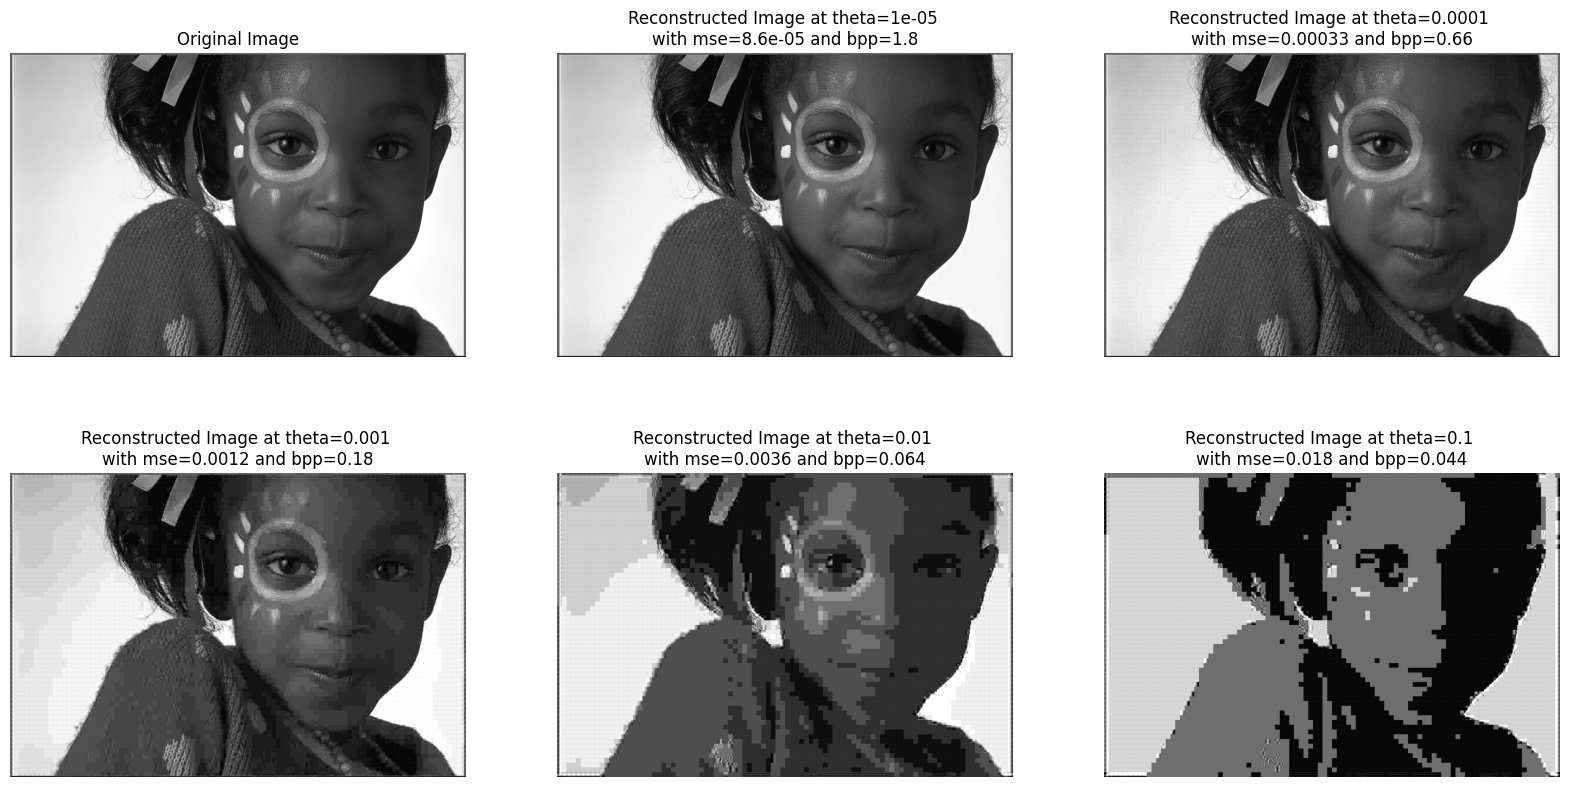

In [26]:

H, W = img_arr.shape
codec = ImageCodec(BLOCK_SIZE, eigenvectors, mean, eigenval)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flat = axes.flatten()
# Display the first image
axes_flat[0].imshow(img_arr, cmap='gray')
axes_flat[0].set_title('Original Image')
axes_flat[0].axis('off')  # Turn off axis numbers and ticks

ax_idx = 1
for theta in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
  compressed_bytes = codec.encode(img_arr, theta=theta)
  bpp = bits_per_pixel(compressed_bytes, H,W)
  reconst = codec.decode(compressed_bytes, H, W, theta=theta)
  mse_val = mse(img_arr, reconst)
  # Display the second image
  axes_flat[ax_idx].imshow(reconst, cmap='gray')
  axes_flat[ax_idx].set_title(f'Reconstructed Image at theta={theta} \nwith mse={mse_val:.2} and bpp={bpp:.2}')
  axes_flat[ax_idx].axis('off')  # Turn off axis numbers and ticks
  ax_idx += 1

# Show the plot
plt.show()


In [27]:
# lets wrap the encode decode of the image into a function so that we can try out different theta values:
def evaluate_img(img_arr, theta):
    H, W = img_arr.shape
    codec = ImageCodec(BLOCK_SIZE, eigenvectors, mean, eigenval)
    compressed_bytes = codec.encode(img_arr, theta=theta)
    bpp = bits_per_pixel(compressed_bytes, H,W)
    reconst = codec.decode(compressed_bytes, H, W, theta=theta)
    mse_val = mse(img_arr, reconst)
    return bpp, mse_val

results = {"bpp": [], "mse": [], "theta": []}
for theta in np.power(10,np.linspace(-4,-2,15)):
    bpp, mse_val = evaluate_img(img_arr, theta)
    results["bpp"].append(bpp)
    results["mse"].append(mse_val)
    results["theta"].append(theta)

import os

# Lets now add JPEG to this plot
def compress_image(img, quality):
    # Open the image

    # Compress the image
    img.save("tmp.jpg", 'JPEG', quality=quality)

    # Calculate the file size in bits
    file_size_bytes = os.path.getsize("tmp.jpg")
    file_size_bits = file_size_bytes * 8

    # Calculate the total number of pixels
    width, height = img.size
    total_pixels = width * height

    # Calculate bits per pixel
    bpp = file_size_bits / total_pixels

    # also lets compute mse
    img_arr = convert_img_to_np_01(img)

    reconst = Image.open("tmp.jpg")
    reconst_arr = convert_img_to_np_01(reconst)

    mse_val = mse(img_arr, reconst_arr)

    return bpp, mse_val


results_jpeg = {"bpp": [], "mse": [], "quality": []}
for quality in np.arange(0,50,2):
    bpp, mse_val = compress_image(sample_img, quality=int(quality))
    results_jpeg["bpp"].append(bpp)
    results_jpeg["mse"].append(mse_val)
    results_jpeg["quality"].append(quality)

combined_results = {"bpp": results["bpp"] + results_jpeg["bpp"], "mse": results["mse"] + results_jpeg["mse"], "codec": len(results["bpp"])*["EE274Codec"] + len(results_jpeg["bpp"])*["JPEG"]}
px.line(combined_results, x="bpp", y="mse", color="codec")

In this exercise, we implemented a simple block-based image compressor which works similar to JPEG in certain bitrate ranges. JPEG is different than our Image codec in a few ways:
- JPEG uses 2D-DCT transform matrix instead of the eigenvectors based KLT we used. The reason is more practical as 2D-DCT can be split into two 1D-DCT transforms which is more efficient.
- JPEG uses a quantization matrix derived empirically, as it tries to optimize for human perceptual quality.
- JPEG uses a different form of lossless coding relying on block-by-block RLE + Huffman coding.

Other modifications to the ImageCodec to improve the RD curve can be
- Try larger block sizes than 8x8.
- Try to experiment with the quantization matrix.
- The coefficients corresponding to the first eigenvector are kind-of important and still correlated across blocks, so maybe some special lossless coding for those might work better.
